# Why are Telco's Customers Churning? 
## A Root Cause Analysis

### Sean Oslin

## Project planning phase

### Project goal/research questions

### Deliverables

1. Jupyter notebook where your work takes place

2. CSV file that predicts churn for each customer

3. Python script that prepares data such that it can be fed into your model

4. Google slide summarizing your model

5. README.md file that contains a link to your google slides presentation, and instructions for how to use your python script(s)


### Minimum viable product

### Null and alternative hypotheses

H<sub>0</sub>:  Telco's data cannot provide any discernable causes for client churn

H<sub>a</sub>:  Reasons for client churn can be elucidated from Telco's data

### Python libraries used for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from math import sqrt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Python programming for this analysis imported from associated text documents

In [2]:
import env
import wrangle_telco
from telco_split_scale import *

  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines internet_service_type_id online_security  ...  \
0           Yes             No                        1              No  ...   
1           Yes            Yes                        1              No  ...   
2           Yes             No                        2              No  ...   
3           Yes             No                        2              No  ...   
4           Yes             No                        2              No  ...   

   payment_type_id monthly_charges total_charges churn contract_type_id  \
0                2            65.6 

### Import prepared Telco data from the text editor to this notebook

In [3]:
df = wrangle_telco.wrangle_telco()

In [4]:
pd.set_option('display.max_columns', None) #prevents 'head' from truncating the number of columns

In [5]:
df.head(5)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type_id,contract_type,internet_service_type_id,internet_service_type,payment_type_id,payment_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,Yes,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No,2,One year,1,DSL,2,Mailed check
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.9,542.4,No,1,Month-to-month,1,DSL,2,Mailed check
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,No,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes,1,Month-to-month,2,Fiber optic,1,Electronic check
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,Yes,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes,1,Month-to-month,2,Fiber optic,1,Electronic check
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,No,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes,1,Month-to-month,2,Fiber optic,2,Mailed check


## First glance at data to assess data structure changes needed before analysis

In [6]:
wrangle_telco.peekatdata(df)

  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines  internet_service_type_id online_security  \
0           Yes             No                         1              No   
1           Yes            Yes                         1              No   
2           Yes             No                         2              No   
3           Yes             No                         2              No   
4           Yes             No                         2              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No          Yes        

### Remove duplicate columns

In [7]:
df = df.loc[:,~df.columns.duplicated()]

In [8]:
cols = df.columns.tolist() #3 columns used for data join have been eliminated
print(cols, end = " ")

['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type_id', 'paperless_billing', 'payment_type_id', 'monthly_charges', 'total_charges', 'churn', 'contract_type', 'internet_service_type', 'payment_type'] 

### Check for duplicate customer ID numbers

In [9]:
duplicateRowsDF = df[df.duplicated(['customer_id'])]
duplicateRowsDF.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type


### Reorder columns so ID number preceeds the description

In [10]:
df = df[['customer_id',
 'gender','senior_citizen','partner','dependents','tenure','phone_service','multiple_lines','internet_service_type_id',\
             'internet_service_type','online_security','online_backup','device_protection','tech_support',\
             'streaming_tv','streaming_movies','contract_type_id','contract_type', 'paperless_billing',\
             'payment_type_id','payment_type','monthly_charges','total_charges','churn']]

### Convert yes/no and female/male variables to binary (0,1)

In [11]:
df.replace(to_replace=['No', 'Yes'], value=[0, 1], inplace = True)

In [12]:
df.replace(to_replace=['No phone service'], value=[0], inplace = True) #convert 'No phone service to 0'

In [13]:
df.replace(to_replace=['Female', 'Male'], value=[0, 1], inplace = True)

In [14]:
df.replace(to_replace=['No internet service'], value=[0], inplace = True)

In [15]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,internet_service_type,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn
0,0002-ORFBO,0,0,1,1,9,1,0,1,DSL,0,1,0,1,1,0,2,One year,1,2,Mailed check,65.6,593.3,0
1,0003-MKNFE,1,0,0,0,9,1,1,1,DSL,0,0,0,0,0,1,1,Month-to-month,0,2,Mailed check,59.9,542.4,0
2,0004-TLHLJ,1,0,0,0,4,1,0,2,Fiber optic,0,0,1,0,0,0,1,Month-to-month,1,1,Electronic check,73.9,280.85,1
3,0011-IGKFF,1,1,1,0,13,1,0,2,Fiber optic,0,1,1,0,1,1,1,Month-to-month,1,1,Electronic check,98.0,1237.85,1
4,0013-EXCHZ,0,1,1,0,3,1,0,2,Fiber optic,0,0,0,1,1,0,1,Month-to-month,1,2,Mailed check,83.9,267.4,1


### Remove null values - all null values removed in MySQL

### Data types adjusted to best suit each variable 

In [16]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 24 columns):
customer_id                 6419 non-null object
gender                      6419 non-null int64
senior_citizen              6419 non-null int64
partner                     6419 non-null int64
dependents                  6419 non-null int64
tenure                      6419 non-null int64
phone_service               6419 non-null int64
multiple_lines              6419 non-null int64
internet_service_type_id    6419 non-null int64
internet_service_type       6419 non-null object
online_security             6419 non-null int64
online_backup               6419 non-null int64
device_protection           6419 non-null int64
tech_support                6419 non-null int64
streaming_tv                6419 non-null int64
streaming_movies            6419 non-null int64
contract_type_id            6419 non-null int64
contract_type               6419 non-null object
paperless_billing         

## Predictive model 1: using all numeric variables

### Split data

In [18]:
X = df.drop(columns=['churn', 'customer_id', 'internet_service_type', 'contract_type', 'payment_type'])
y = pd.DataFrame(df['churn'])

In [19]:
df_t = split_my_data(X, y)

In [20]:
X_train, X_test, y_train, y_test = split_my_data(X,y)
X_train.head(1)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges
5677,0,1,0,0,46,1,1,2,0,1,1,0,1,1,1,1,1,104.45,4863.85


### Decision tree model

In [21]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)

In [22]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [23]:
y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 1])

In [24]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.61251504, 0.38748496],
       [0.7539267 , 0.2460733 ],
       [0.8058104 , 0.1941896 ],
       ...,
       [0.62081784, 0.37918216],
       [0.7539267 , 0.2460733 ],
       [0.8058104 , 0.1941896 ]])

In [25]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


Interpreting a classification report

Precision: the higher this number is, the more you were able to pinpoint all positives correctly. If this is a low score, you predicted a lot of positives where there were none. tp / (tp + fp)

Recall: if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there. tp / (tp + fn)

f1-score: The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.

Support: number of occurrences of each class in where y is true.
Collapse

In [26]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3447
           1       0.64      0.34      0.44      1046

    accuracy                           0.80      4493
   macro avg       0.73      0.64      0.66      4493
weighted avg       0.78      0.80      0.78      4493



In [27]:
cm = pd.DataFrame(confusion_matrix(y_train, y_pred))
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.values.sum() - (FP + FN + TP)
print ('True negative', '\n', TN, '\n')
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ('True positive rate (Sensitivity)', '\n', TPR, '\n')
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print ('True negative rate (Specificity)', '\n', TNR, '\n')
# Precision or positive predictive value
PPV = TP/(TP+FP)
print ('Positive predictive value (Precision)', '\n', PPV, '\n')
# Negative predictive value
NPV = TN/(TN+FN)
print ('Negative predictive value', '\n', NPV, '\n')
# Fall out or false positive rate
FPR = FP/(FP+TN)
print ('False positive rate', '\n', FPR, '\n')
# False negative rate
FNR = FN/(TP+FN)
print ('False negative rate', '\n', FNR, '\n')
# False discovery rate
FDR = FP/(TP+FP)
print ('False discovery rate', '\n', FDR, '\n')
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Overall accuracy', '\n', ACC)

True negative 
 0     354
1    3247
dtype: int64 

True positive rate (Sensitivity) 
 0    0.941979
1    0.338432
dtype: float64 

True negative rate (Specificity) 
 0    0.338432
1    0.941979
dtype: float64 

Positive predictive value (Precision) 
 0    0.824321
1    0.638989
dtype: float64 

Negative predictive value 
 0    0.638989
1    0.824321
dtype: float64 

False positive rate 
 0    0.661568
1    0.058021
dtype: float64 

False negative rate 
 0    0.058021
1    0.661568
dtype: float64 

False discovery rate 
 0    0.175679
1    0.361011
dtype: float64 

Overall accuracy 
 0    0.801469
1    0.801469
dtype: float64


### Split data

In [28]:
standard_scaler(X_train, X_test) #used standard scaler

(        gender  senior_citizen   partner  dependents    tenure  phone_service  \
 5677 -1.017287        2.221547 -1.027761   -0.666854  0.459778       0.324902   
 5025  0.983007       -0.450137 -1.027761   -0.666854 -0.177888       0.324902   
 2238 -1.017287       -0.450137 -1.027761   -0.666854  0.077178       0.324902   
 499   0.983007       -0.450137  0.972989    1.499578  0.969911       0.324902   
 4682  0.983007       -0.450137 -1.027761   -0.666854 -1.325687       0.324902   
 6320  0.983007       -0.450137  0.972989    1.499578  1.565065       0.324902   
 550  -1.017287        2.221547  0.972989   -0.666854 -0.390443       0.324902   
 777   0.983007       -0.450137 -1.027761    1.499578 -1.240664       0.324902   
 6242 -1.017287       -0.450137  0.972989   -0.666854  0.587311       0.324902   
 620  -1.017287       -0.450137  0.972989    1.499578  1.565065       0.324902   
 952  -1.017287       -0.450137  0.972989    1.499578 -1.070620       0.324902   
 2760 -1.017287 

### How do the dependent variables correlate with each other?

In [29]:
X_train.corr(method ='pearson') 

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges
gender,1.000000,0.003584,0.004652,0.009307,0.014675,-0.014882,-0.015659,-0.002717,-0.007484,-0.005784,-0.004262,-0.011959,0.008118,-0.006170,0.013381,-0.002722,-0.003791,-0.015025,0.003468
senior_citizen,0.003584,1.000000,0.009682,-0.212576,0.016692,0.002589,0.134480,-0.033367,-0.020438,0.077933,0.070964,-0.076350,0.105673,0.132922,-0.149383,0.150091,-0.079899,0.221857,0.115027
partner,0.004652,0.009682,1.000000,0.453003,0.341563,0.024808,0.127003,0.002149,0.114377,0.117264,0.134881,0.099651,0.106774,0.102940,0.267815,-0.008842,0.105831,0.075762,0.287870
dependents,0.009307,-0.212576,0.453003,1.000000,0.156847,0.001725,-0.023402,0.029418,0.070485,0.023145,0.008039,0.074918,-0.019338,-0.040399,0.239965,-0.103399,0.112733,-0.112489,0.061651
tenure,0.014675,0.016692,0.341563,0.156847,1.000000,-0.000510,0.283372,-0.017539,0.293015,0.332351,0.319115,0.290696,0.234957,0.236341,0.649711,-0.001953,0.308017,0.199799,0.803391
phone_service,-0.014882,0.002589,0.024808,0.001725,-0.000510,1.000000,0.296823,0.385638,-0.087501,-0.062604,-0.071891,-0.103504,-0.031950,-0.038084,-0.002822,0.006599,-0.002819,0.246464,0.116499
multiple_lines,-0.015659,0.134480,0.127003,-0.023402,0.283372,0.296823,1.000000,0.018334,0.068684,0.184223,0.177840,0.064959,0.235281,0.230023,0.054694,0.163105,0.008863,0.481816,0.442592
internet_service_type_id,-0.002717,-0.033367,0.002149,0.029418,-0.017539,0.385638,0.018334,1.000000,-0.405947,-0.331759,-0.310153,-0.407688,-0.252589,-0.263008,0.120480,-0.144582,-0.001401,-0.326522,-0.185600
online_security,-0.007484,-0.020438,0.114377,0.070485,0.293015,-0.087501,0.068684,-0.405947,1.000000,0.261240,0.255637,0.345977,0.151307,0.154393,0.210551,0.001575,0.157472,0.285630,0.389213
online_backup,-0.005784,0.077933,0.117264,0.023145,0.332351,-0.062604,0.184223,-0.331759,0.261240,1.000000,0.289069,0.282276,0.279839,0.271144,0.114883,0.140723,0.077145,0.440393,0.501592


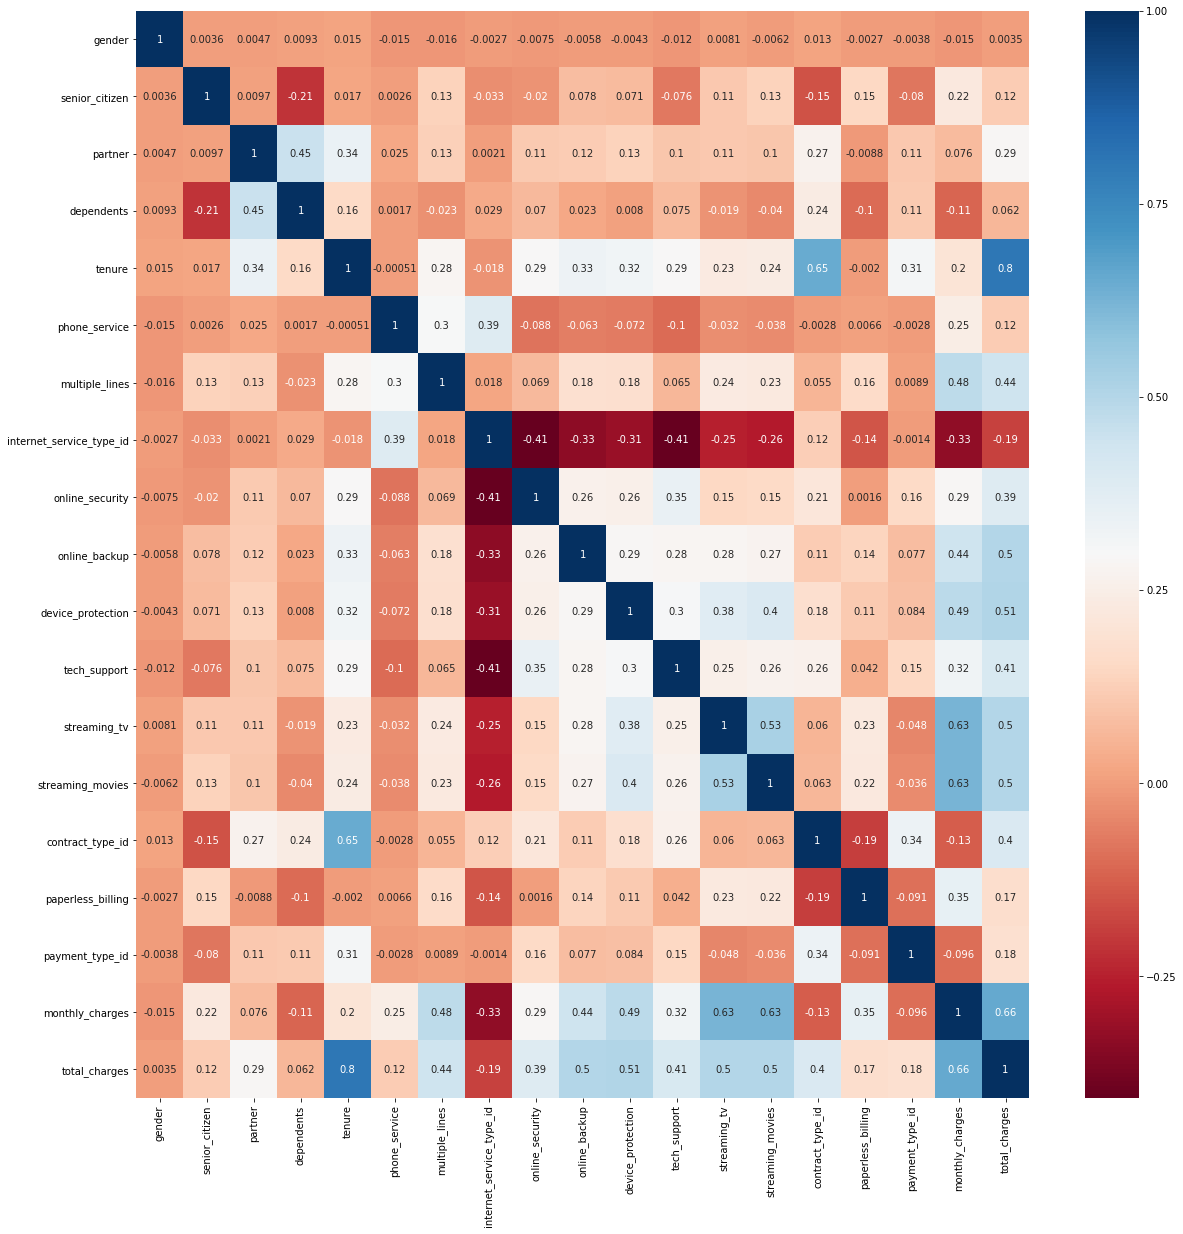

In [30]:
plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), cmap='RdBu', annot=True)


### High correlation among X variables to determine candidates for combining or eliminating
Partner and dependents: .45

Streaming movies and streaming TV: .53

Contract type and tenure: .65

### Combine 'partner' and 'dependents' variables into 'family'

In [31]:
X_train['family'] = X_train.partner + X_train.dependents

In [32]:
X_train['family'].replace({2:1}, inplace = True)

In [33]:
X_test['family'] = X_train.partner + X_train.dependents

In [34]:
X_test['family'].replace({2:1}, inplace = True)

### Combine two streaming variables to 'streaming'

In [35]:
X_train['streaming'] = X_train.streaming_tv + X_train.streaming_movies

In [36]:
X_train['streaming'].replace({2:1}, inplace = True)

In [37]:
X_test['streaming'] = X_train.streaming_tv + X_train.streaming_movies

In [38]:
X_test['streaming'].replace({2:1}, inplace = True)

In [39]:
X_train = X_train.drop(columns=['streaming_tv', 'streaming_movies', 'partner', 'dependents'])

### Combine 4 on-line service variables to 'services'

In [40]:
X_train['services'] = X_train.online_security + X_train.online_backup + X_train.device_protection 
+ X_train.tech_support

5677    0
5025    0
2238    0
499     0
4682    0
6320    0
550     0
777     0
6242    0
620     0
952     0
2760    1
2448    1
4442    0
1064    0
5116    1
3991    0
5139    0
4827    0
1398    0
4037    1
385     0
212     1
4863    1
1318    0
3653    0
4438    1
1532    0
5001    1
1103    0
       ..
6077    1
5679    0
6416    0
39      0
2050    1
4547    0
1847    0
1092    0
3325    1
2894    1
1363    1
3481    0
111     1
6368    0
942     0
5664    0
4169    1
4143    0
6257    0
96      0
5857    0
1593    0
5243    0
6250    0
5862    0
5218    0
4060    1
1346    0
3454    0
3582    0
Name: tech_support, Length: 4493, dtype: int64

In [41]:
X_train['services'].replace({2:1, 3:1, 4:1}, inplace = True)

In [42]:
X_test['services'] = X_train.online_security + X_train.online_backup + X_train.device_protection 
+ X_train.tech_support

5677    0
5025    0
2238    0
499     0
4682    0
6320    0
550     0
777     0
6242    0
620     0
952     0
2760    1
2448    1
4442    0
1064    0
5116    1
3991    0
5139    0
4827    0
1398    0
4037    1
385     0
212     1
4863    1
1318    0
3653    0
4438    1
1532    0
5001    1
1103    0
       ..
6077    1
5679    0
6416    0
39      0
2050    1
4547    0
1847    0
1092    0
3325    1
2894    1
1363    1
3481    0
111     1
6368    0
942     0
5664    0
4169    1
4143    0
6257    0
96      0
5857    0
1593    0
5243    0
6250    0
5862    0
5218    0
4060    1
1346    0
3454    0
3582    0
Name: tech_support, Length: 4493, dtype: int64

In [43]:
X_test['services'].replace({2:1, 3:1, 4:1}, inplace = True)

In [44]:
X_train = X_train.drop(columns=['online_security', 'online_backup', 'device_protection', 'tech_support'])

In [45]:
X_test = X_test.drop(columns=['online_security', 'online_backup', 'device_protection', 'tech_support'])

### Drop payment and billing variables as unnecessary for analysis

In [46]:
X_train = X_train.drop(columns=['payment_type_id', 'paperless_billing'])

In [47]:
X_test = X_test.drop(columns=['payment_type_id', 'paperless_billing'])

In [48]:
X_train.head()

,gender,senior_citizen,tenure,phone_service,multiple_lines,internet_service_type_id,contract_type_id,monthly_charges,total_charges,family,streaming,services
5677,0,1,46,1,1,2,1,104.45,4863.85,0,1,1
5025,1,0,31,1,1,2,2,103.45,3066.45,0,1,1
2238,0,0,37,1,0,1,1,64.75,2345.20,0,1,0
499,1,0,58,1,0,3,2,19.55,1108.80,1,0,0
4682,1,0,4,1,0,2,1,88.45,370.65,0,1,0


## Split columns with 3+ possible responses into indvididual columns

In [49]:
def encode(X_train, X_test, col_name):

    encoded_values = sorted(list(X_train['internet_service_type_id'].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    X_train.encoded = int_encoder.fit_transform(X_train['internet_service_type_id'])
    X_test.encoded = int_encoder.transform(X_test['internet_service_type_id'])

    # create 2D np arrays of the encoded variable (in train and test)
    X_train_array = np.array(X_train.encoded).reshape(len(X_train.encoded),1)
    X_test_array = np.array(X_test.encoded).reshape(len(X_test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    X_train_ohe = ohe.fit_transform(X_train_array)
    X_test_ohe = ohe.transform(X_test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    X_train_encoded = pd.DataFrame(data=X_train_ohe,
                            columns=encoded_values, index=X_train.index)
    X_train = X_train.join(X_train_encoded)

    X_test_encoded = pd.DataFrame(data=X_test_ohe,
                               columns=encoded_values, index=X_test.index)
    X_test = X_test.join(X_test_encoded)

    return X_train, X_test

X_train, X_test = encode(X_train, X_test, col_name = 'internet_service_type_id')

In [50]:
X_train.head()

,gender,senior_citizen,tenure,phone_service,multiple_lines,internet_service_type_id,contract_type_id,monthly_charges,total_charges,family,streaming,services,1,2,3
5677,0,1,46,1,1,2,1,104.45,4863.85,0,1,1,0.0,1.0,0.0
5025,1,0,31,1,1,2,2,103.45,3066.45,0,1,1,0.0,1.0,0.0
2238,0,0,37,1,0,1,1,64.75,2345.20,0,1,0,1.0,0.0,0.0
499,1,0,58,1,0,3,2,19.55,1108.80,1,0,0,0.0,0.0,1.0
4682,1,0,4,1,0,2,1,88.45,370.65,0,1,0,0.0,1.0,0.0


In [51]:
### Rename newly created columns

In [52]:
X_train.rename(columns={1 :'DSL', 2 : 'fiber_optic', 3 : 'no_internet'}, inplace = True)
X_test.rename(columns={1 :'DSL', 2 : 'fiber_optic', 3 : 'no_internet'}, inplace = True)

In [53]:
def encode(X_train, X_test, col_name):

    encoded_values = sorted(list(X_train['contract_type_id'].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    X_train.encoded = int_encoder.fit_transform(X_train['contract_type_id'])
    X_test.encoded = int_encoder.transform(X_test['contract_type_id'])

    # create 2D np arrays of the encoded variable (in train and test)
    X_train_array = np.array(X_train.encoded).reshape(len(X_train.encoded),1)
    X_test_array = np.array(X_test.encoded).reshape(len(X_test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    X_train_ohe = ohe.fit_transform(X_train_array)
    X_test_ohe = ohe.transform(X_test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    X_train_encoded = pd.DataFrame(data=X_train_ohe,
                            columns=encoded_values, index=X_train.index)
    X_train = X_train.join(X_train_encoded)

    X_test_encoded = pd.DataFrame(data=X_test_ohe,
                               columns=encoded_values, index=X_test.index)
    X_test = X_test.join(X_test_encoded)

    return X_train, X_test

X_train, X_test = encode(X_train, X_test, col_name = 'contract_type_id')

In [54]:
X_train.rename(columns={1 :'monthly', 2 : 'one_year', 3 : 'two_year'}, inplace = True)
X_test.rename(columns={1 :'monthly', 2 : 'one_year', 3 : 'two_year'}, inplace = True)

In [55]:
X_train.drop(columns= 'internet_service_type_id', inplace = True)
X_test.drop(columns= 'internet_service_type_id', inplace = True)

In [56]:
X_train.drop(columns= 'contract_type_id', inplace = True)
X_test.drop(columns= 'contract_type_id', inplace = True)

In [57]:
X_train["tenure_years"] = (X_train.tenure/12).apply(np.floor)
X_test["tenure_years"] = (X_train.tenure/12).apply(np.floor)

In [58]:
X_train.head()

,gender,senior_citizen,tenure,phone_service,multiple_lines,monthly_charges,total_charges,family,streaming,services,DSL,fiber_optic,no_internet,monthly,one_year,two_year,tenure_years
5677,0,1,46,1,1,104.45,4863.85,0,1,1,0.0,1.0,0.0,1.0,0.0,0.0,3.0
5025,1,0,31,1,1,103.45,3066.45,0,1,1,0.0,1.0,0.0,0.0,1.0,0.0,2.0
2238,0,0,37,1,0,64.75,2345.20,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
499,1,0,58,1,0,19.55,1108.80,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,4.0
4682,1,0,4,1,0,88.45,370.65,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# Scale data

In [59]:
standard_scaler(X_train, X_test) #used standard scaler

(        gender  senior_citizen    tenure  phone_service  multiple_lines  \
 5677 -1.017287        2.221547  0.459778       0.324902        1.094596   
 5025  0.983007       -0.450137 -0.177888       0.324902        1.094596   
 2238 -1.017287       -0.450137  0.077178       0.324902       -0.913579   
 499   0.983007       -0.450137  0.969911       0.324902       -0.913579   
 4682  0.983007       -0.450137 -1.325687       0.324902       -0.913579   
 6320  0.983007       -0.450137  1.565065       0.324902        1.094596   
 550  -1.017287        2.221547 -0.390443       0.324902       -0.913579   
 777   0.983007       -0.450137 -1.240664       0.324902        1.094596   
 6242 -1.017287       -0.450137  0.587311       0.324902       -0.913579   
 620  -1.017287       -0.450137  1.565065       0.324902       -0.913579   
 952  -1.017287       -0.450137 -1.070620       0.324902       -0.913579   
 2760 -1.017287       -0.450137  0.757355       0.324902        1.094596   
 2448 -1.017

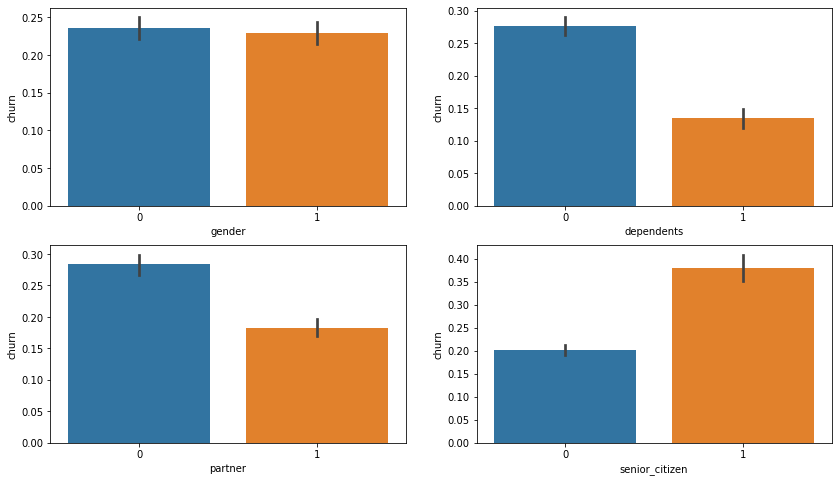

In [60]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
sns.barplot(x="gender", y="churn", data=df)
plt.subplot(2,2,2)
sns.barplot(x="dependents", y="churn", data=df)
plt.subplot(2,2,3)
sns.barplot(x="partner", y="churn", data=df)
plt.subplot(2,2,4)
sns.barplot(x="senior_citizen", y="churn", data=df)